In [341]:
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import locale
import matplotlib.pyplot as plt
import seaborn as sns

# First the Scraping

In [306]:
locale.setlocale(locale.LC_ALL, "sv_SE.UTF-8")

'sv_SE.UTF-8'

In [30]:
url = "https://www.hemnet.se/salda/bostader?location_ids%5B%5D=505426"

In [41]:
def pull_page(url):
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)

    driver.get(url)
    soup = bs(driver.page_source)

    driver.close()
    return soup

def hemnet_pull_all(url):
    # first get how many pages there are
    soup = pull_page(url)
    key = "div.pagination__item"
    pages_num = int(soup.select(key)[-2].text)
    soup_list = [soup]

    for page in range(2, pages_num+1):
        soup = pull_page(f"{url}&page={page}")
        soup_list.append(soup)

    return soup_list

def flatten(t):
    return [item for sublist in t for item in sublist]

In [161]:
soup_list = hemnet_pull_all(url)



====== WebDriver manager ======
Current google-chrome version is 94.0.4606
Get LATEST driver version for 94.0.4606
Driver [/Users/ivenwinkelmann/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache


====== WebDriver manager ======
Current google-chrome version is 94.0.4606
Get LATEST driver version for 94.0.4606
Driver [/Users/ivenwinkelmann/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache


====== WebDriver manager ======
Current google-chrome version is 94.0.4606
Get LATEST driver version for 94.0.4606
Driver [/Users/ivenwinkelmann/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache


====== WebDriver manager ======
Current google-chrome version is 94.0.4606
Get LATEST driver version for 94.0.4606
Driver [/Users/ivenwinkelmann/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache


In [463]:
# generate list of entries (containers)
entry_key = "li.sold-results__normal-hit"

entry_list = []
for soup in soup_list:
    entry_list += soup.select(entry_key)

entry_list = flatten(entry_list)
entry_list = [i for i in entry_list if i != "\n"]

# define selector keys
keys = {
      "street": "span.item-result-meta-attribute-is-bold.item-link.qa-selling-price-title"
    , "area": "div.sold-property-listing__location > div"
    , "size_m2": "div.sold-property-listing__size > div > div.sold-property-listing__subheading.sold-property-listing--left"
    , "fee": "div.sold-property-listing__fee"
    , "price": "div.sold-property-listing__price > div:nth-child(1) > span"
    , "price_p_m2": "div.sold-property-listing__price-per-m2.sold-property-listing--left"
    , "date": "div.sold-property-listing__price > div:nth-child(2) > div.sold-property-listing__sold-date.sold-property-listing--left"
    , "change": "div.sold-property-listing__price-change"
    , "broker": "div.sold-property-listing__broker"
    , "labels": "div.sold-property-listing__labels"
}

# pull items and generate df
pd_dct = {i: [] for i in keys}

for entry in entry_list:
    for cat, key in keys.items():
        try:
            pd_dct[cat].append(entry.select(key)[0].text)
        except:
            pd_dct[cat].append(np.nan)

df = pd.DataFrame(pd_dct)

# fix street column
# df["street"] = df["street"].str.extract(r"([^,-]+\d+)")

# create rooms column
df["rooms"] = df["size_m2"].str.extract(r"(?<=\s)(\d.*?)(?=\xa0rum)")
df["rooms"] = df["rooms"].str.strip().str.replace(",", ".").astype("float")

# fix size column
df["size_m2"] = df["size_m2"].str.extract(r"(\d.*?)(?=m)")
df["size_m2"] = df["size_m2"].str.strip().str.replace(",", ".").astype("float")

# fix fee column
df["fee"] = df["fee"].str.replace(" ", "").str.replace(r"\xa0", "").str.replace("kr/mån", "").str.strip().astype("int")

# fix price column
df["price"] = df["price"].str.replace(" ", "").str.replace(r"\xa0", "").str.replace("Slutpris", "")\
    .str.replace("kr", "").str.strip().astype("int")

# fix price_p_m2 column
df["price_p_m2"] = df["price_p_m2"].str.replace(" ", "").str.replace(r"\xa0", "")\
    .str.replace("kr/m²", "").str.strip().astype("int")
    
# fix date column
df["date"] = df["date"].str.replace("Såld", "").str.strip()
df["date"] = pd.to_datetime(df["date"], format="%d %B %Y") 

# fix change column
df["change"] = df["change"].str.replace("%", "").str.replace("±", "").str.strip().astype("float")

# fix broker column
df["broker"] = df["broker"].str.strip()

# add balcony
df["balcony"] = df["labels"].str.contains("Balkong")

# add month sold
df["month_sold"] = df["date"].dt.month

# add year sold
df["year_sold"] = df["date"].dt.year

# add month sold normalized against mean of the year
df["price_m2_yr_norm"] = df["price_p_m2"] / df.groupby(["year_sold"])["price_p_m2"].transform("mean")

# add fee p sqm
df["fee_p_m2"] = df["fee"] / df["size_m2"]

# add housenumber
df["housenumber"] = df["street"].str.extract(r"(\d+)").astype("int")


/var/folders/xd/r6vshhv97rzf66qh0dqdxzsh0000gp/T/ipykernel_26124/3051108485.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  df["fee"] = df["fee"].str.replace(" ", "").str.replace(r"\xa0", "").str.replace("kr/mån", "").str.strip().astype("int")
/var/folders/xd/r6vshhv97rzf66qh0dqdxzsh0000gp/T/ipykernel_26124/3051108485.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
  df["price"] = df["price"].str.replace(" ", "").str.replace(r"\xa0", "").str.replace("Slutpris", "")\
/var/folders/xd/r6vshhv97rzf66qh0dqdxzsh0000gp/T/ipykernel_26124/3051108485.py:56: FutureWarning: The default value of regex will change from True to False in a future version.
  df["price_p_m2"] = df["price_p_m2"].str.replace(" ", "").str.replace(r"\xa0", "")\


# Now the Analysis
## Guiding Questions
- What are the differences between housenumbers?
    - Value? Number of Apartments sold?
- How did the fee change over time?
- Which broker is most performant?
- How is the general price trend?
- Which months outperform the average?
- Different categories of apartment sizes?
- What size is the sweetspot for value?
- How many apartments sold per year?

In [482]:
house_order = pd.Index([2, 4, 6, 8, 10, 12, 27, 25, 23, 21, 19, 17, 15, 13, 11, 9, 7, 5], name="housenumber")

<AxesSubplot:xlabel='month_sold', ylabel='price_m2_yr_norm'>

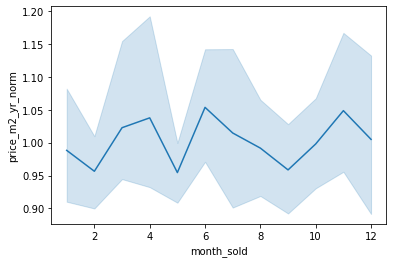

In [389]:
sns.lineplot(data=df, x="month_sold", y="price_m2_yr_norm")

<AxesSubplot:xlabel='year_sold', ylabel='price_p_m2'>

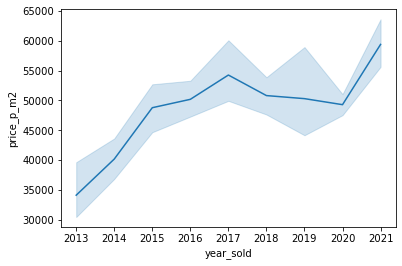

In [366]:
sns.lineplot(data=df, x="year_sold", y="price_p_m2")

In [360]:
df["broker"].value_counts(normalize=True)

Länsförsäkringar Fastighetsförmedling Solna         0.291667
Fastighetsbyrån Solna                               0.220238
Notar                                               0.059524
Erik Olsson Fastighetsförmedling                    0.059524
Svensk Fastighetsförmedling                         0.047619
Svensk Fastighetsförmedling Solna                   0.041667
Svenska Mäklarhuset Solna                           0.035714
Bjurfors Solna Sundbyberg                           0.029762
HusmanHagberg Solna                                 0.029762
Unik Fastighetsförmedling AB                        0.023810
Mäklarhuset Solna                                   0.023810
SkandiaMäklarna Solna                               0.023810
MOHV Solna                                          0.017857
Bronze Fastighetsförmedling AB                      0.017857
Svenska Mäklarhuset Sundbyberg                      0.011905
One Fastighetsmäkleri AB                            0.011905
Länsförsäkringar Fastigh

<AxesSubplot:xlabel='date', ylabel='fee_p_m2'>

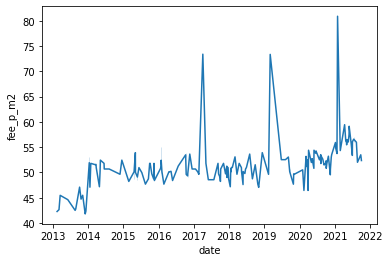

In [364]:
sns.lineplot(data=df, x="date", y="fee_p_m2")

<AxesSubplot:xlabel='housenumber', ylabel='price_p_m2'>

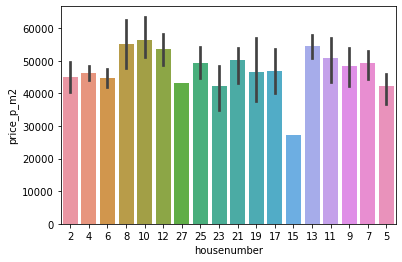

In [483]:
sns.barplot(data=df, x="housenumber", y="price_p_m2", order=house_order)

Text(0.5, 1.0, 'Apartments sold per house')

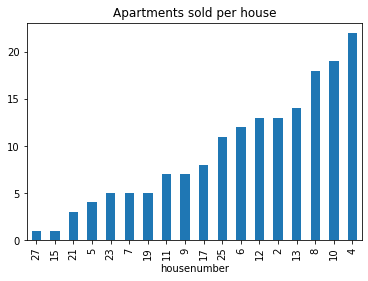

In [488]:
ax = df.groupby(["housenumber"])["street"].count().sort_values().plot.bar()
plt.title("Apartments sold per house")

In [427]:
df["size_m2"].value_counts()

94.0     22
83.0     21
103.0    21
65.5     19
87.0     16
86.5     14
63.5     12
44.5     11
47.0     11
108.0     4
58.0      3
24.0      3
46.5      2
89.0      2
44.0      2
103.5     1
65.0      1
55.0      1
33.0      1
84.0      1
Name: size_m2, dtype: int64

Text(0.5, 1.0, 'Apartments sold per year')

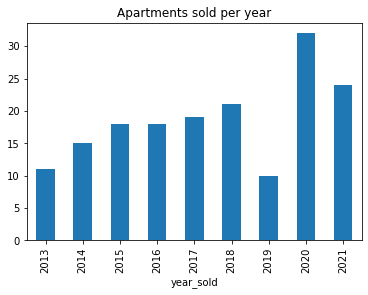

In [444]:
df.groupby("year_sold")["street"].count().plot.bar()
plt.title("Apartments sold per year")